# QUAIL Pipeline
**Quick-RAIL, A Simplified RAIL Degradation Pipeline**

This pipeline heavily references the pipeline created in RAIL's Degradation Demo notebook, which can be found [rendered on ReadTheDocs](https://rail-hub.readthedocs.io/projects/rail-notebooks/en/latest/rendered/creation_examples/degradation-demo.html) and in [notebook form on GitHub](https://github.com/LSSTDESC/rail/blob/main/examples/creation_examples/degradation-demo.ipynb).

## Welcome!

The recommended order of action is as follows: 

_(However, because the pipeline is already able to run as-is, you are free to skip any steps and come back to them later.)_

1. Read through the whole notebook.
1. Implement an Incorrectness stage.
    1. Each row will have some change of its redshift value being changed to a random value.
    1. This kind of degrader is especially useful in cases where you need a pipeline to test for the impact of incorrect values in your training set, and how it will impact your estimations on your test set. In essense, how sensitive is your estimator to bad values in your training set? If even a tenth of a percent of values being bad will ruin things, that's good to know up front!
1. Implement InvRedshiftIncompleteness.
    1. This degrader applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.
    1. If this speaks to you, consider other incompleteness degrader stages you could implement. Different survival functions can be applied to different bands (see [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias)), and this will result in different redshift distributions. 
    1. We recommend using scipy's [continuous distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions), which have survival functions as a method called `sf` (eg, see [alpha.sf docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alpha.html#scipy.stats.alpha:~:text=sf(x%2C%20a%2C%20loc%3D0%2C%20scale%3D1))).
1. Once you have at least a couple degraders to choose from, take some time to play around with the pipeline and see how different adding and removing degraders in different combinations will affect the results.
1. Implement LSSTErrorModel to replace the BadErrorModel.
    1. More info on how the error model is generated is in the LSST docs.
    2. If you'd like a hint, we recommend looking at John Franklin's code in his implementation of the LSSTErrorModel ([repo here](https://github.com/jfcrenshaw/photerr/tree/main/photerr)).
1. Implement better plotting functionality (as described at the end).


## Setting things up

Start by making a conda environment (or translate these instructions for your preferred environment manager):

`conda create -n quail python=3.10`

Install the following packages:
```
pip install pzflow
pip install pz-rail-pzflow
pip install matplotlib
pip install ipykernel
```

Make your conda environment available as a kernel for your notebook:

`python -m ipykernel install --user --name quail`

In [1]:
# Then our imports:
from numbers import Number
import os

import pzflow
import matplotlib.pyplot as plt

## Generate our truth data from PZFlow

In [2]:
flow_file = os.path.join(
    os.path.dirname(pzflow.__file__), "example_files", "example-flow.pzflow.pkl"
)
flowCreator_truth = pzflow.Flow(file=flow_file)

n_samples = int(1e5)
samples_truth = flowCreator_truth.sample(n_samples, seed=0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
samples_truth

,redshift,u,g,r,i,z,y
0,0.890625,27.370831,26.712662,26.025223,25.327188,25.016500,24.926821
1,1.978239,29.557049,28.361185,27.587231,27.238544,26.628109,26.248560
2,0.974287,26.566015,25.937716,24.787413,23.872456,23.139563,22.832047
3,1.317979,29.042730,28.274593,27.501106,26.648790,26.091450,25.346500
4,1.386366,26.292624,25.774778,25.429958,24.806530,24.367950,23.700010
...,...,...,...,...,...,...,...
99995,2.147172,26.550978,26.349937,26.135286,26.082020,25.911032,25.558136
99996,1.457508,27.362207,27.036276,26.823139,26.420132,26.110037,25.524904
99997,1.372992,27.736044,27.271955,26.887581,26.416138,26.043434,25.456165
99998,0.855022,28.044554,27.327118,26.599014,25.862333,25.592169,25.506388


## QUAIL Base Classes

We'll be using a few highly simplified versions of RAIL classes, namely:
- QuailStage (accompanied by a NothingStage, to demonstrate how we'll inherit for our other degrader stages)
- DataStore
- Pipeline

In [4]:
from abc import ABC, abstractmethod


class QuailStage(ABC):
    """A class for the QuailStage stage."""

    def __init__(self, name):
        """Constructor.

        Parameters
        ----------
        name : str
            The (human-readable) name of the stage (this will be used in the Pipeline's __repr__).
        """
        self.name = name
        self.data_in = None
        self.data_out = None

    @abstractmethod
    def run(self):
        """To be implemented in subclasses. This should set the data_out attribute."""
        pass

In [5]:
class NothingStage(QuailStage):
    """A stage that does nothing."""

    def __init__(self, name):
        """Constructor.

        Parameters
        ----------
        name : str
            The name of the stage.
        """
        super().__init__(name)

    def run(self):
        """Run the stage."""
        self.data_out = self.data_in

## Degrader 1: BadErrorModel

We start by creating an incredibly naive error model as a stand-in for the LSSTErrorModel.

This will generate u_err, g_err, etc. columns for us, but there's no scientific basis for the values it generates.

In [6]:
class BadErrorModel(QuailStage):
    """A stage that applies bad errors."""

    def __init__(self, name):
        """Constructor.

        Parameters
        ----------
        name : str
            The name of the stage.
        """
        super().__init__(name)

    def apply_errors(self):
        """Apply the errors to the input data.

        Returns
        -------
        errors : pandas.DataFrame
            The input data with errors applied.
        """
        # create a copy of the input data
        errors = self.data_in.copy()
        for col in ["u", "g", "r", "i", "z", "y"]:
            # create a new column with the error
            errors[f"{col}_err"] = 0.01 * self.data_in[col]
        # reorder the columns
        errors = errors[
            [
                "redshift",
                "u",
                "u_err",
                "g",
                "g_err",
                "r",
                "r_err",
                "i",
                "i_err",
                "z",
                "z_err",
                "y",
                "y_err",
            ]
        ]
        return errors

    def run(self):
        """Run the stage."""
        self.data_out = self.apply_errors()

    def plot(self):
        """Plot the truth data and the errors."""
        if self.data_out is None:
            raise ValueError("You must run the stage first.")

        fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

        for band in "ugrizy":
            # pull out the magnitudes and errors
            mags = self.data_out[band].to_numpy()
            errs = self.data_out[band + "_err"].to_numpy()

            # sort them by magnitude
            mags, errs = mags[mags.argsort()], errs[mags.argsort()]

            # plot errs vs mags
            ax.plot(mags, errs, label=band)

        ax.legend()
        ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")
        plt.show()

## Degrader 2: QuantityCut

This degrader is based on our QuantityCut example in the degradation demo notebook.

In [7]:
class QuantityCut(QuailStage):
    """Applies a cut to the input data based on a quantity.

    Parameters
    ----------
    name : str
        The name of the stage.
    cuts : dict
        A dictionary of cuts to apply to the data.

    Notes
    -----
    The cut keys should be the names of columns you wish to make cuts on.

    The cut values should be either:
    - a number, which is the maximum value. E.g. if the dictionary
    contains "i": 25, then values of i > 25 are cut from the sample.
    - an iterable, which is the range of acceptable values. E.g. if the
    dictionary contains "redshift": (1.5, 2.3), then redshifts outside that
    range are cut from the sample.
    """

    def __init__(self, name="QuantityCut", cuts=None):
        """Constructor."""
        super().__init__(name=name)
        self.cuts = cuts
        self.data_out = None

    def apply_cut(self):
        """Apply the cuts to the input data.

        Returns
        -------
        data_out : pandas.DataFrame
            The input data with the cut applied.
        """
        # create a copy of the input data
        data_out = self.data_in.copy()

        # Apply the cuts
        for col, cut in self.cuts.items():
            if isinstance(cut, Number):
                # Apply cut as maximum value
                data_out = data_out[data_out[col] <= cut]
            elif hasattr(cut, "__iter__"):
                # Apply cut as range of acceptable values
                data_out = data_out[
                    (data_out[col] >= cut[0]) & (data_out[col] <= cut[1])
                ]
            else:
                raise TypeError("Cut must be a number or an iterable of (min, max)")

        return data_out

    def run(self):
        """Run the stage."""
        data_out = self.apply_cut()
        self.data_out = data_out

## Degrader 3: InvRedshiftIncompleteness

This one is up to you! Feel free to reference 

In [8]:
# Potentially, write an InvRedshiftIncompleteness for them here

## Making the Pipeline

In [9]:
class DataStore(dict):
    def __init__(self):
        dict.__init__(self)

    def __getattr__(self, key):  # Code copied from RAIL's DataStore
        """Allow attribute-like parameter access"""
        try:
            return self.__getitem__(key)
        except KeyError as msg:
            # Kludge to get docstrings to work
            if key in ["__objclass__"]:  # pragma: no cover
                return None
            raise KeyError from msg

    def __repr__(self):  # Feel free to change this output into whatever you like!
        """Prints the DataStore keys and shapes in a human-readable format."""
        s = "DataStore\n"
        for key in self.keys():
            s += f"  {key}:\n\t{self[key].shape}\n"
        return s

In [10]:
class Pipeline:
    def __init__(self, data_store, stages):
        self.data_store = data_store
        self.stages = stages

    def run(self):
        current_data = self.data_store["input_data"]
        for stage in self.stages:
            print(f"Running stage: {stage.name}")
            stage.data_in = current_data
            stage.run()
            self.data_store[f"{stage.name}_data"] = stage.data_out
            current_data = stage.data_out
        self.data_store["output_data"] = current_data

    def __repr__(self):
        s = "Pipeline\n"
        for stage in self.stages:
            s += f"  {stage.name}\n"
        return s

    def get_stage(self, stage_name):
        for stage in self.stages:
            if stage.name == stage_name:
                return stage
        print(f"Stage {stage_name} not found in pipeline.")
        return None

    def plot(self):
        pass

    def save(self):
        pass

In [11]:
DS = DataStore()
DS["input_data"] = samples_truth

stages = [
    NothingStage("do_nothing"),
    BadErrorModel("bad_error_model"),
    QuantityCut("quality_cut", cuts={"i": 25.3}),
]

pipeline = Pipeline(DS, stages)

In [12]:
# Our DataStore before running the pipeline

DS

DataStore
  input_data:
	(100000, 7)

In [13]:
pipeline.run()

Running stage: do_nothing
Running stage: bad_error_model
Running stage: quality_cut


In [14]:
# Our DataStore after running the pipeline

DS

DataStore
  input_data:
	(100000, 7)
  do_nothing_data:
	(100000, 7)
  bad_error_model_data:
	(100000, 13)
  quality_cut_data:
	(51834, 13)
  output_data:
	(51834, 13)

## Looking at the data

Poke around and see the changes you've made! Note that overloading the `__getattr__` in our DataStore class lets us access data via `DS.key` syntax.

In [15]:
DS.quality_cut_data

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
2,0.974287,26.566015,0.265660,25.937716,0.259377,24.787413,0.247874,23.872456,0.238725,23.139563,0.231396,22.832047,0.228320
4,1.386366,26.292624,0.262926,25.774778,0.257748,25.429958,0.254300,24.806530,0.248065,24.367950,0.243679,23.700010,0.237000
5,0.781594,25.260242,0.252602,24.760660,0.247607,24.190180,0.241902,23.490292,0.234903,23.254755,0.232548,23.142416,0.231424
7,0.241211,25.242653,0.252427,24.297722,0.242977,23.660122,0.236601,23.434032,0.234340,23.290936,0.232909,23.230427,0.232304
8,0.679428,25.597193,0.255972,24.576437,0.245764,23.358215,0.233582,22.386454,0.223865,22.045204,0.220452,21.766762,0.217668
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99985,0.655446,27.938505,0.279385,26.373728,0.263737,24.935675,0.249357,23.836836,0.238368,23.449919,0.234499,23.138636,0.231386
99987,0.533671,25.913956,0.259140,23.062687,0.230627,21.498058,0.214981,20.530348,0.205303,20.118841,0.201188,19.873356,0.198734
99990,0.890143,25.153250,0.251532,24.985104,0.249851,24.572035,0.245720,23.884956,0.238850,23.539755,0.235398,23.409142,0.234091
99992,0.857895,26.644793,0.266448,26.049953,0.260500,24.878302,0.248783,23.759336,0.237593,23.270391,0.232704,23.129339,0.231293


## Plotting

We can access the plot method of our error model like so:

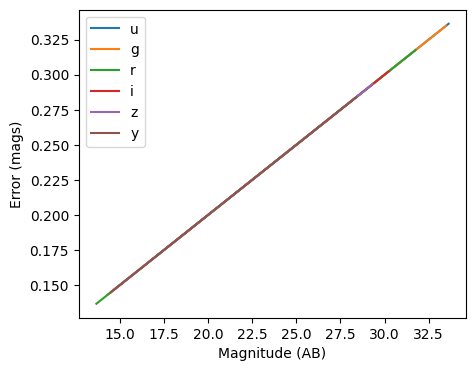

In [16]:
pipeline.get_stage(
    "bad_error_model"
).plot()  # Compare this to the plot in the RAIL degrader notebook,
# where we see very different errors!

And here, we grab a snippet of plotting code from the degrader demo notebook. 

As it is now, we can compare our DataStore's input data and its output data. 

What else would you want to show? And where would you fit the code in?

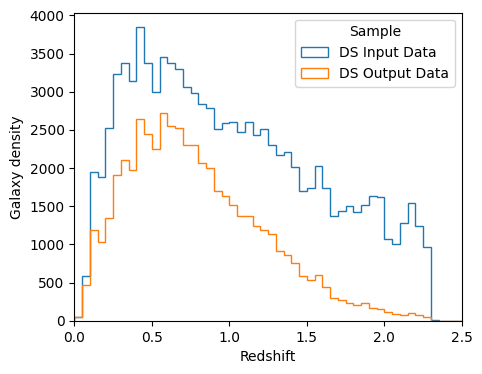

In [17]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": False,  # both versions are useful!
    "histtype": "step",
}

ax.hist(DS["input_data"]["redshift"], label="DS Input Data", **hist_settings)
ax.hist(DS["output_data"]["redshift"], label="DS Output Data", **hist_settings)
# One could extend this to plot the intermediate data, too...

ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

In [18]:
class MyClass:
    mutable_list = []
    
    imutable_string = "My String"
    


In [19]:
MyClass.imutable_string = "New String"
MyClass.imutable_string

'New String'